# Strava Data Exploration and Analysis
by Ben Merrill

There is a growing amount of data in the field of sports and excercise. Strava keeps track of our data as we excercise, helping us to look deeper into the effects of exercising and make better goals. This notebook will be a breif exploration of my client's Strava experience. In this notebook, we use scatter plots, histograms, heatmaps, and interactive mapping to tell the story of my clients exercise adventures in Michigan.

We will make conclusions about exercise time, speed, heart rate vs. total distance, and exercise location.

# Rules Used for Better Figures

In Nicholas Rougier's article, 'Ten Simple Rules for Better Figures' (https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003833), we get a look at some of the rules that we can use to create more compelling visualizations. Five of those ten priciples that we use in this notebook are:
 - Know your audience - We know the client well, after having had a few months together. We also know that his goal in this analysis is to better understand his exercise data.
 - Captions are not optional - We thoroughly describe our steps and processes before creating each visualization in order to make an easily recognizable narritive.
 - Do not trust the defaults - This notebook will update many attributes of our figures, helping to better represent the data and our findings.
 - Use color effectively - In each visualization, color helps us encode other attributes in our data, add depth to our plotting and maps, and make our visualizations less binary
 - Avoid chartjunk - Thankfully many of our libraries don't make using chartjunk very easy. We will avoid chartjunk in order to prove our point in a more relatable way

# Libraries Used

We will use matplotlib, pandas, numpy, folium, datetime, and altair.

Now, to the data cleaning!

In [1]:
#import our libraries and our data
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import folium
from datetime import datetime
%matplotlib inline

In [2]:
#Our visualizations will be in seaborn style
mpl.style.use('seaborn')

#Read in our data
data = pd.read_csv('strava.csv')

#Drop columns with no data or redundant features
data = data.drop(columns = ['unknown_87', 'unknown_88', 'unknown_90', 'Cadence', 'fractional_cadence'])

#Some basic formatting for grouping
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['date'] = data['timestamp'].dt.date

#Turn lattitude and longitude into degrees
data['position_lat'] = data['position_lat'] * ( 180 / 2**31 )
data['position_long'] = data['position_long'] * ( 180 / 2**31 )

#Let's look at our resulting dataset
print('Strava data shape:', data.shape)
print('Columns in our dataset: ', data.columns.values)
data.head()

Strava data shape: (40649, 18)
Columns in our dataset:  ['Air Power' 'Form Power' 'Ground Time' 'Leg Spring Stiffness' 'Power'
 'Vertical Oscillation' 'altitude' 'cadence' 'datafile' 'distance'
 'enhanced_altitude' 'enhanced_speed' 'heart_rate' 'position_lat'
 'position_long' 'speed' 'timestamp' 'date']


,Air Power,Form Power,Ground Time,Leg Spring Stiffness,Power,Vertical Oscillation,altitude,cadence,datafile,distance,enhanced_altitude,enhanced_speed,heart_rate,position_lat,position_long,speed,timestamp,date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,activities/2675855419.fit.gz,0.00,NaN,0.000,68.0,NaN,NaN,0.0,2019-07-08 21:04:03,2019-07-08
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,activities/2675855419.fit.gz,0.00,NaN,0.000,68.0,NaN,NaN,0.0,2019-07-08 21:04:04,2019-07-08
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,activities/2675855419.fit.gz,1.32,NaN,1.316,71.0,NaN,NaN,1316.0,2019-07-08 21:04:07,2019-07-08
3,NaN,NaN,NaN,NaN,NaN,NaN,3747.0,77.0,activities/2675855419.fit.gz,12.19,249.4,1.866,77.0,42.281006,-83.740547,1866.0,2019-07-08 21:04:14,2019-07-08
4,NaN,NaN,NaN,NaN,NaN,NaN,3798.0,77.0,activities/2675855419.fit.gz,14.08,259.6,1.894,80.0,42.281043,-83.740622,1894.0,2019-07-08 21:04:15,2019-07-08


# The Data

This is data that is timestamped nearly every second during exercizing. Because of this frequent timestamp, we can do some cool basic aggregations of features of each exercise event. There's alot to look at here, so let's describe it with some fundimental statistical methods.

In [3]:
print(data.describe())

          Air Power    Form Power   Ground Time  Leg Spring Stiffness  \
count  17842.000000  17842.000000  17847.000000          17842.000000   
mean       1.872100     99.485932    325.934107             13.138571   
std        2.777476     13.866222     71.773687              2.039567   
min        0.000000      0.000000      0.000000              0.000000   
25%        1.000000     97.000000    308.000000             13.000000   
50%        1.000000    101.000000    326.000000             13.375000   
75%        2.000000    105.000000    340.000000             13.750000   
max       48.000000    125.000000   1732.000000             16.875000   

              Power  Vertical Oscillation      altitude       cadence  \
count  17847.000000          17847.000000  14905.000000  40627.000000   
mean     301.459797              6.458074   3846.184368     72.781254   
std       48.540552              1.135497    134.262498     17.743728   
min        0.000000              0.000000   3555.0

There is a huge range of distances here, from 1000 meters to nearly 40000! It also looks like most of your exercise has been in the same area, in a relative lattitude and longitude. That begs the following question:

# Where have you exercised?
Using an interactive map with the Folium library, we'd like to see where you've run. 

In [4]:
#Let's look at all of the places you've run!

#Create a map in Ann Arbor
m=folium.Map(location=[42.27,-83.72], zoom_start=13)

#Map each run by its day, lattitude, and longitude
for date in data['date'].unique():
    long = data[data['timestamp'].dt.date == date]['position_long'].dropna()
    lat = data[data['timestamp'].dt.date == date]['position_lat'].dropna()
    temp_line = folium.PolyLine(locations=zip(lat, long), weight=2,color='blue').add_to(m)

#Let's look at it
display(m)

It looks like my client has been all over Ann Arbor. They are also quite a traveller, with a few trips down I-94, and what looks like an outlier in the Detroit suburbs.

Some of the most common roads travelled on are:
 - Miller Avenue
 - Brooks Street (Look, it's named after you!)
 - Pomona Road
 - Packard Street
 - Around some Elementary and Middle Schools
 - Along the Huron River
 
Now, we've got a feel for where exercise happens. Now we can address few other small questions about individual events and exercise habits.

# How Often Does the Client Exercise?

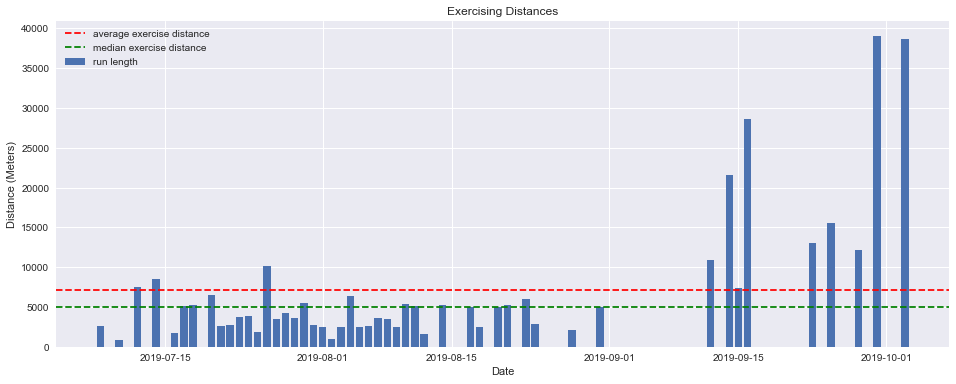

In [5]:
#Create distances grouped by event
max_distance = data.resample('D', on='timestamp')['distance'].max()

#Create a typical plot size
mpl.rcParams['figure.figsize'] = [16.0,6.0]

#Plot your exercise by distance
plt.bar(max_distance.index, max_distance, label='run length')

#Create vertical lines to display basic distance stats
plt.axhline(y=max_distance.mean(), color='r', linestyle='--', label='average exercise distance')
plt.axhline(y=max_distance.median(), color='g', linestyle='--', label='median exercise distance')

#Create legend and axis labels
plt.xlabel('Date')
plt.ylabel('Distance (Meters)')
plt.title('Exercising Distances')
plt.legend()

Wow, the client gets out alot! Judging by the distances here, in the map, and in the describe function, they did alot of running in July and August, and began cycling in  September and October. As we answer our next question, let's take a look at aggregating the total time spent exercising, seperated by whether you were on the bike or running.

# What time do you exercise?

In [6]:
#Create a column for biking or running
running_mask = (data['timestamp'] - datetime(2019, 9, 5)).apply(lambda x: x.days) < 0
data['activity'] = ['Running' if event == True else 'Biking' for event in running_mask]
data['hour'] = data['timestamp'].apply(lambda x: x.hour)

#Sort by proportion of time spent each hour
time_proportion_hours = data.groupby(['activity', 'hour'])['date'].count()
time_proportion_hours = (time_proportion_hours/sum(time_proportion_hours)).reset_index()
time_proportion_hours['hour'] = time_proportion_hours['hour'].astype('int')
time_proportion_hours['date'] = time_proportion_hours['date'].astype('float64')

#Build a stacked bar chart
alt.Chart(time_proportion_hours).mark_bar().encode(
    x=alt.X('hour:Q', 
            scale=alt.Scale(domain=(0, 23)),
            axis = alt.Axis(title='Time of Day')),
    y=alt.Y('sum(date)',
            axis = alt.Axis(title='Proportion of Total Time Spent')),
    color='activity:N'
).properties(
    title='Time of Day for Exercise'
)


alt.Chart(...)

It looks like most of the exercise was done after dinner, since, more than 50% of the exercise was done between 7PM and 10PM, and surprisingly, there were some very long late night runs. It also looks like during the day, the client didn't cycle. 

Now, to do another short analysis, let's look at some of the other attributes shown in the data and see how they correlate using a Scatter Plot Matrix chart.

# How do Speed, Distance, Heart Rate, and Altitude Correlate?

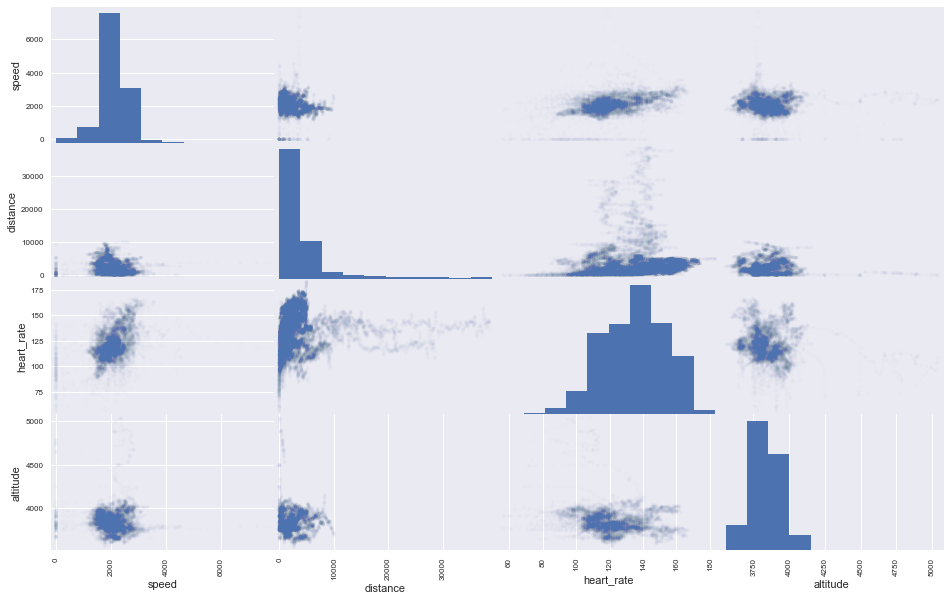

In [7]:
show_in_splom = ['speed', 'distance', 'heart_rate', 'altitude']

fig = pd.plotting.scatter_matrix(data[show_in_splom], alpha=.01, figsize=(16,10))
fig;

This shows us practical correlation in the data. For instance, as we might expect, speed and heart rate have a slightly positive correlation. I chose a low alpha on this splom to show the density of the data. It's also interesting to see what happens to heart rate as distance goes up. It seems that if distance increases, heart rate does not. The shortest distances seem to have the highest heart rates. To check if this is true, lets build a heat map.

# How to Heart Rates and Total Distance Compare?

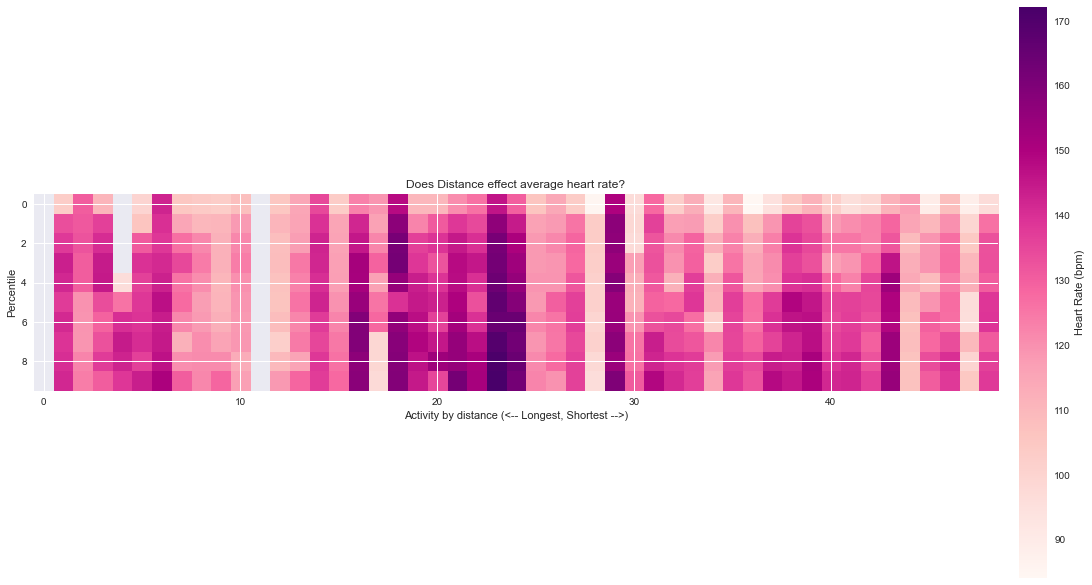

In [8]:
#Are the shorter runs usually harder on the body,having a higher heart rate?

#Building a dataframe measuring each activity's heart rate by quantiles 
avg_heart_rate = {}
for date in data['date'].unique():
    temp_day_data = data[data['date'] == date].copy()
    distance = temp_day_data['distance'].max()
    
    #Cut our data into quantiles and groupby quantiles, finding the mean heart rate of each percentage
    temp_day_data['quantiles'] = pd.qcut(temp_day_data['timestamp'], q=10)
    heart_rates = temp_day_data.groupby('quantiles')['heart_rate'].mean().reset_index(drop=True)
    
    #Append it to our dictionary
    avg_heart_rate[distance] = heart_rates
avg_heart_rate = pd.DataFrame(avg_heart_rate)

#Sorting columns by distance of event
column_order = sorted(avg_heart_rate.columns, reverse=True)
avg_heart_rate = avg_heart_rate[column_order]

#Creating a heatmaps
fig=plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(avg_heart_rate, cmap='RdPu')
plt.xlabel('Activity by distance (<-- Longest, Shortest -->)')
plt.ylabel('Percentile')
plt.title('Does Distance effect average heart rate?')
plt.colorbar(fraction=0.046, pad=0.02).set_label('Heart Rate (bpm)')
plt.show()

In this chart, we see the percentiles on the y-axis, outlining the first 10%, 20%, etc. of the event, and the activity on the x-axis, sorted by the distance, with the longest event at the 0, and the shortest at the around 50. The colors show the overall heart rate for each event by quantile, with the darkest events having the highest heart rates.

We know that the first ten columns are bicycling, showing a higher average heart rate for the longer rides. We see the same when we look at the running events, where the highest heart-rate columns tend to be in the middle, and the lightest are on the shorter end. We also see that for most events, the heart rate tends to stay fairly level, not changing abruptly over time, but often with a slow start, as we might expect, since when starting to exercise, you don't immediately have a high heart rate.

# Conclusion

In this notebook, we saw the location and other attributes of our client's exercise, such as time of day, activity, distances, and habits on shorter or longer runs and bike rides. To explore further, we could measure more correlation of figures, or predict a common path, or new path that could be interesting for the client to explore. 

# Note
Our client didn't want their data shared, so we only show the ipynb and pdf files.